# spatial neighbourhoods

In [1]:
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import matplotlib.pyplot as plt 
import numpy as np
def spatial_neigbourshoods(anndata,
                           cluster_label = 'leiden_0.5',
                           max_distance_allowed = 200):
    
    import numpy as np
    import scanpy as sc
    import pandas as pd
    from sklearn.metrics.pairwise import euclidean_distances
    
    distances_input=np.array([anndata.obs['x_centroid'],anndata.obs['y_centroid']])
    din=distances_input.transpose()
    distances=euclidean_distances(din, din)
    dist_df=pd.DataFrame(distances)
    max_distance_allowed=max_distance_allowed
    dist_binary=((dist_df<max_distance_allowed)*1)*((dist_df!=
                                                     0)*1)
    np.sum(np.sum(dist_binary))
    dist_binary['name']=list(anndata.obs[cluster_label])
    distbinsum=dist_binary.groupby('name').sum()
    adata=sc.AnnData(distbinsum.transpose())
    adata.obs=anndata.obs

    return adata


In [2]:
adata = sc.read_h5ad('../data/mtDNA_DSB_5k_clustered_LLM_anno.h5ad')

# run spatial neigbourshoods

In [3]:
my_runs = []  # empty list

my_runs.append(adata.obs['run'].unique()[0])

In [4]:
my_runs

['output-XETG00045__0060539__RB4282__20250917__105852']

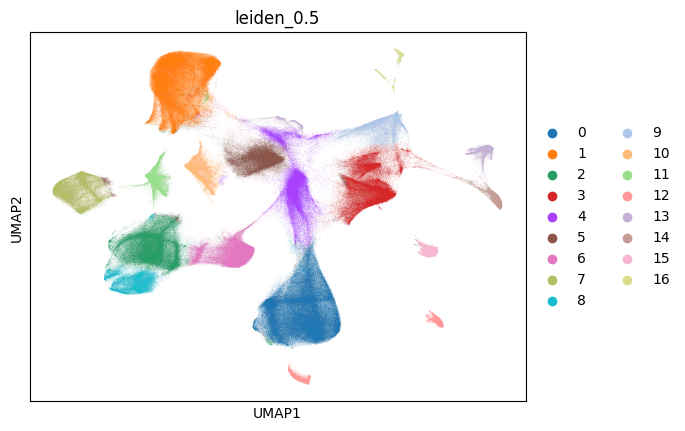

In [5]:
sc.pl.umap(adata, color = 'leiden_0.5')

In [6]:
ad_sn_list = []
for i in my_runs:
    print(i)
    ad_sub_sample = adata[adata.obs['run'] == i]

output-XETG00045__0060539__RB4282__20250917__105852


In [7]:
ad_sub_sample

View of AnnData object with n_obs × n_vars = 81721 × 5101
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'n_genes_by_counts', 'n_counts', 'n_genes', 'leiden_0.5', 'leiden_1', 'leiden_2', 'cell_class'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_class_colors', 'leiden', 'leiden_0.5_colors', 'leiden_1_colors', 'leiden_2_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
ad_sn_list = []
for i in my_runs:
    print(i)
    ad_sub_sample = adata[adata.obs['run'] == i]
    ad_sn = spatial_neigbourshoods(anndata = ad_sub_sample, cluster_label = 'leiden_0.5',max_distance_allowed = 500) #50 #600 #200#550
    ad_sn_list.append(ad_sn)

output-XETG00045__0060539__RB4282__20250917__105852


In [ ]:
ad_sn = sc.concat(ad_sn_list, join = 'outer', fill_value = 0)

In [ ]:
spatial = np.array(ad_sn.obs[['x_centroid','y_centroid']])
ad_sn.obsm['spatial'] = spatial

In [ ]:
sc.pp.neighbors(ad_sn, n_neighbors=10)
sc.tl.umap(ad_sn,min_dist=0.2)

In [ ]:
for i in [0.01,  0.04, 0.06,0.1,0.5]: 
    key = 'local_neighborhood_'+str(i)
    if key in ad_sn.obs.columns: 
        sc.pl.umap(ad_sn,color=[key],  s = 10)#,save='UMAP_10X_colors.svg')
    else: 
        sc.tl.leiden(ad_sn,resolution=i, key_added = key)
        sc.pl.umap(ad_sn,color=[key],  s = 10)#,save='UMAP_10X_colors.svg')

In [ ]:
for run in ad_sn.obs['grid_label'].unique():
    print(run)
    ad_int = ad_sn[ad_sn.obs['grid_label'] == run]
    print(ad_int.obs.course.unique())

    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=15, color = 'local_neighborhood_0.1')
    plt.show()
    

In [ ]:
import scanpy as sc
import pandas as pd
import scipy
import matplotlib.pyplot as plt

def post_merge(df, labels, post_merge_cutoff, linkage_method='single', 
               linkage_metric='correlation', fcluster_criterion='distance', name='', save=False):
    Z = scipy.cluster.hierarchy.linkage(df.T, method=linkage_method, metric=linkage_metric)
    merged_labels_short = scipy.cluster.hierarchy.fcluster(Z, post_merge_cutoff, criterion=fcluster_criterion)

    # map cluster name to merged label
    label_conversion = dict(zip(df.columns, merged_labels_short))
    new_labels = [label_conversion[i] for i in labels]

    # Plot
    fig, ax = plt.subplots(figsize=(20, 10))
    scipy.cluster.hierarchy.dendrogram(Z, labels=df.columns, color_threshold=post_merge_cutoff, ax=ax)
    ax.hlines(post_merge_cutoff, 0, ax.get_xlim()[1])
    ax.set_title('Merged clusters')
    ax.set_ylabel(linkage_metric, fontsize=20)
    ax.set_xlabel('Pre-merge cluster labels', fontsize=20)
    ax.tick_params(axis="x", labelrotation=90, labelsize=10)  # <-- rotate tick labels
    plt.show()
    if save:
        fig.savefig(f"{name}.svg", dpi=500)
    
    return new_labels

In [ ]:
# Compute cluster-level mean expression
cluster_key = 'local_neighborhood_0.1'
expr = pd.DataFrame(ad_sn.X, index=ad_sn.obs_names, columns=ad_sn.var_names)
cluster_means = expr.groupby(ad_sn.obs[cluster_key]).mean().T  # genes x clusters

# Run post-merge
merged_labels = post_merge(cluster_means, labels=ad_sn.obs[cluster_key].tolist(),
                           post_merge_cutoff=0.18,
                           linkage_metric='correlation',
                           linkage_method='average',
                           name='SupFig3Dend',
                           save=False)

# Add new merged label to AnnData object
ad_sn.obs['merged_cluster'] = merged_labels
ad_sn.obs['merged_cluster'] = ad_sn.obs['merged_cluster'].astype(str)

In [ ]:
sc.pl.umap(ad_sn, color='merged_cluster')

In [ ]:
for run in ad_sn.obs['grid_label'].unique():
    print(run)
    ad_int = ad_sn[ad_sn.obs['grid_label'] == run]
    print(ad_int.obs.course.unique())

    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=15, color = 'merged_cluster')
    plt.show()
    

In [ ]:
sc.tl.rank_genes_groups(ad_sn, groupby='merged_cluster', method='wilcoxon')
# See top 5 marker genes per cluster
sc.pl.rank_genes_groups(ad_sn, n_genes=25, sharey=False)

marker_genes = pd.DataFrame({
    group: ad_sn.uns['rank_genes_groups']['names'][group][:10]
    for group in ad_sn.uns['rank_genes_groups']['names'].dtype.names
})
marker_genes.head()
#marker_genes.to_csv('../data/broad_markers_leiden0-5.csv')
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

In [ ]:
dict(zip(ad_sn.obs["merged_cluster"].cat.categories, ad_sn.obs["merged_cluster"].cat.categories))

In [ ]:
anno = {'1': 'Lesion I',
 '2': 'Lesion II',
 '3': 'Lesion III',
 '4': 'Lesion IV',
 '5': 'Lesion V',
 '6': 'Lesion VI',
 '7': 'Lesion VII',
 '8': 'Lesion VIII',
 '9': 'Grey matter',
 '10': 'Dorsal horn',
 '11': 'White matter',
 '12': 'Grey matter',
 '13': 'Grey matter',
        
 '14': 'Central canal',
 '15': 'Vasculature',
 '16': 'Dorsal root ganglion',
 '17': 'Dorsal root ganglion',

 }

In [ ]:
ad_sn.obs['compartment'] = ad_sn.obs["merged_cluster"].map(anno)

In [ ]:
sc.pl.umap(ad_sn, color='compartment')

In [ ]:
import scanpy as sc

In [ ]:
for run in ad_sn.obs['sample_id'].unique():
    print(run)
    ad_int = ad_sn[ad_sn.obs['sample_id'] == run]
    print(ad_int.obs.course.unique())

    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=20, color = 'compartment')
    plt.show()
    

In [ ]:
sc.pl.umap(ad_sn, color='compartment')

In [ ]:
import scanpy as sc

In [ ]:
for run in ad_sn.obs['sample_id'].unique():
    print(run)
    ad_int = ad_sn[ad_sn.obs['sample_id'] == run]
    print(ad_int.obs.course.unique())

    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=20, color = 'compartment')
    plt.show()
    

In [ ]:
# Compute cluster-level mean expression
cluster_key = 'compartment'
expr = pd.DataFrame(ad_sn.X, index=ad_sn.obs_names, columns=ad_sn.var_names)
cluster_means = expr.groupby(ad_sn.obs[cluster_key]).mean().T  # genes x clusters

# Run post-merge
merged_labels = post_merge(cluster_means, labels=ad_sn.obs[cluster_key].tolist(),
                           post_merge_cutoff=0.0,
                           linkage_metric='correlation',
                           linkage_method='average',
                           name='SupFig3Dend',
                           save=False)

# Add new merged label to AnnData object
ad_sn.obs['merged_cluster'] = merged_labels
ad_sn.obs['merged_cluster'] = ad_sn.obs['merged_cluster'].astype(str)

In [ ]:

sc.pl.umap(ad_sn, color='compartment')

In [ ]:
obs_key = "compartment"

# categories and their colors
cats = ad_sn.obs[obs_key].cat.categories
cols = ad_sn.uns[f"{obs_key}_colors"]

compartment_palette = dict(zip(cats, cols))

In [ ]:
sc.tl.rank_genes_groups(ad_sn, groupby='compartment', method='wilcoxon')
# See top 5 marker genes per cluster
sc.pl.rank_genes_groups(ad_sn, n_genes=25, sharey=False)

marker_genes = pd.DataFrame({
    group: ad_sn.uns['rank_genes_groups']['names'][group][:10]
    for group in ad_sn.uns['rank_genes_groups']['names'].dtype.names
})
marker_genes.head()
#marker_genes.to_csv('../data/broad_markers_leiden0-5.csv')
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()
    print(" ".join(genes))
    print(' ')

In [ ]:
import pandas as pd

# contingency table: counts of cells per (course, merged_cluster)
comp = pd.crosstab(ad_sn.obs["course"], ad_sn.obs["compartment"])

# convert to fractions per course
comp_frac = comp.div(comp.sum(axis=1), axis=0)

print(comp.head())       # absolute counts
print(comp_frac.head())  # relative composition

In [ ]:
palette = compartment_palette  # extracted from adata
cols = comp_frac.columns.tolist()

missing = [c for c in cols if c not in palette]
if missing:
    print("No color for:", missing)

colors = [palette.get(c, "#BBBBBB") for c in cols]  # fallback grey

ax = comp_frac.plot(
    kind="bar", stacked=True, figsize=(10, 6),
    color=colors, edgecolor="none"
)
ax.set_ylabel("Fraction of cells")
ax.set_title("Compartment composition across courses")
ax.legend(title="Compartment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
MODELS = {'MOG': {'baseline': 'MOG CFA',
  'courses': ['non symptomatic',
   'early onset',
   'chronic peak',
   'chronic long']},
 'PLP': {'baseline': 'PLP CFA',
  'courses': ['onset I',
   'onset II',
   'peak I',
   'monophasic',
   'remitt I',
   'peak II',
   'remitt II',
   'peak III']}}



In [ ]:
import matplotlib.pyplot as plt

# define which compartments to keep
lesion_cols = [c for c in comp_frac.columns if c.startswith("Lesion")]

def plot_lesion_dynamics_by_model(comp_frac, MODELS, palette):
    n_models = len(MODELS)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5), sharey=True)
    if n_models == 1:
        axes = [axes]

    for ax, (model, cfg) in zip(axes, MODELS.items()):
        # order timepoints for this model
        time_order = [cfg["baseline"]] + cfg["courses"]
        idx = [t for t in time_order if t in comp_frac.index]
        if not idx:
            ax.set_title(f"{model} (no matching courses)")
            continue

        df = comp_frac.loc[idx, lesion_cols]  # <-- restrict to lesions only

        # plot each lesion as line
        for comp in df.columns:
            ax.plot(df.index, df[comp], marker="o",
                    label=comp, color=palette.get(comp, "#BBBBBB"),
                    lw=2)

        ax.set_title(f"{model}")
        ax.set_xlabel("Course")
        ax.set_ylabel("Fraction of cells")
        ax.set_xticks(range(len(idx)))
        ax.set_xticklabels(idx, rotation=45, ha="right")

    # single legend outside
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Lesion", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Example call
plot_lesion_dynamics_by_model(comp_frac, MODELS, compartment_palette)

In [ ]:
ad_sn.write('../../../data/neighborhoods_subset.h5ad')

# construct full adata for spatial neighbourhood mapping

In [ ]:
ad_sn_list = []
for i in ad.obs['sample_id'].unique():
    print(i)
    ad_sub_sample = ad[ad.obs['sample_id'] == i]
    ad_sn_ = spatial_neigbourshoods(anndata = ad_sub_sample, cluster_label = 'cell_type_compartment',max_distance_allowed = 70) #50 #600 #200#550
    ad_sn_list.append(ad_sn_)

In [ ]:
ad_sn_all = sc.concat(ad_sn_list, join = 'outer', fill_value = 0)

# run ingest for label mapping

In [ ]:
ad_sn_all2.obs_names_make_unique()

In [ ]:
ad_sn.obs_names_make_unique()

In [ ]:
def wipe_neighbors(adata, key="neighbors"):
    if key in adata.uns:
        u = adata.uns[key]
        for kk in ("distances_key","connectivities_key"):
            if kk in u and u[kk] in adata.obsp:
                del adata.obsp[u[kk]]
        del adata.uns[key]
    for k in list(adata.obsp.keys()):
        if k.endswith(("distances","connectivities")) or k in ("distances","connectivities"):
            del adata.obsp[k]

wipe_neighbors(ad_sn)

In [ ]:
import numpy as np, scanpy as sc

# Make sure ref has a PCA for the *current* genes
if "X_pca" not in ad_sn.obsm or ad_sn.obsm["X_pca"].shape[0] != ad_sn.n_obs:
    sc.tl.pca(ad_sn, n_comps=min(50, ad_sn.n_vars))

X = ad_sn.obsm["X_pca"]
if np.isnan(X).any() or np.isinf(X).any():
    # Drop bad cells (or handle as you prefer)
    good = ~np.isnan(X).any(1) & ~np.isinf(X).any(1)
    ad_sn._inplace_subset_obs(good)
    sc.tl.pca(ad_sn, n_comps=min(50, ad_sn.n_vars))
    X = ad_sn.obsm["X_pca"]

In [ ]:
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp

k = min(15, ad_sn.n_obs-1)

nbrs = NearestNeighbors(n_neighbors=k+1, metric="euclidean").fit(X)
dist, idx = nbrs.kneighbors(X)

# remove self (first column is usually self; if not, drop whichever equals i)
n = ad_sn.n_obs
row_ids = np.arange(n)
# find self position per row
self_pos = np.argmax(idx == row_ids[:,None], axis=1)  # position where neighbor equals self
mask = np.ones_like(idx, dtype=bool)
mask[row_ids, self_pos] = False
# keep first k neighbors after removing self
idx2  = idx[mask].reshape(n, k)
dist2 = dist[mask].reshape(n, k)

# build CSR matrices
rows = np.repeat(row_ids, k)
cols = idx2.ravel()
dataD = dist2.ravel()
dataC = np.ones_like(dataD, dtype=float)

D_csr = sp.csr_matrix((dataD, (rows, cols)), shape=(n, n))
C_csr = sp.csr_matrix((dataC, (rows, cols)), shape=(n, n))

# register under a clean key
ad_sn.obsp["neighbors_ingest_distances"] = D_csr
ad_sn.obsp["neighbors_ingest_connectivities"] = C_csr
ad_sn.uns["neighbors_ingest"] = {
    "connectivities_key": "neighbors_ingest_connectivities",
    "distances_key": "neighbors_ingest_distances",
    "params": {"n_neighbors": k, "method": "sklearn", "random_state": 0, "metric": "euclidean"},
}

In [ ]:
ad_sn_all

In [ ]:
ad_sn

In [ ]:
lens = np.array([len(r) for r in D_csr.tolil().rows])
print("Unique neighbor counts:", np.unique(lens))  # should be [k]


In [ ]:
ad_sn_all.X = ad_sn_all.X.astype(float)
ad_sn.X = ad_sn.X.astype(float)

In [ ]:
# Map query onto this reference graph
sc.tl.ingest(
    ad_sn_all,              # query
    ad_sn,                  # reference
    obs="compartment",      # or a list of obs keys in newer Scanpy
    neighbors_key="neighbors_ingest",
)

In [ ]:
ad_sn_all.obs

In [ ]:
sc.pl.umap(ad_sn_all, color='compartment')

In [ ]:
import scanpy as sc

In [ ]:
spatial = np.array(ad_sn_all.obs[['x_centroid','y_centroid']])
ad_sn_all.obsm['spatial'] = spatial

In [ ]:
for run in ad_sn_all.obs['grid_label'].unique():
    print(run)
    ad_int = ad_sn_all[ad_sn_all.obs['grid_label'] == run]
    print(ad_int.obs.course.unique())

    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=10, color = 'compartment')
    plt.show()
    

In [ ]:
import pandas as pd

# contingency table: counts of cells per (course, merged_cluster)
comp = pd.crosstab(ad_sn_all.obs["course"], ad_sn_all.obs["compartment"])

# convert to fractions per course
comp_frac = comp.div(comp.sum(axis=1), axis=0)

print(comp.head())       # absolute counts
print(comp_frac.head())  # relative composition

In [ ]:
palette = compartment_palette  # extracted from adata
cols = comp_frac.columns.tolist()

missing = [c for c in cols if c not in palette]
if missing:
    print("No color for:", missing)

colors = [palette.get(c, "#BBBBBB") for c in cols]  # fallback grey

ax = comp_frac.plot(
    kind="bar", stacked=True, figsize=(10, 6),
    color=colors, edgecolor="none"
)
ax.set_ylabel("Fraction of cells")
ax.set_title("Compartment composition across courses")
ax.legend(title="Compartment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()